# 风格迁移PyTorch示例代码

## 在这里可以输入原始图像文件（内容以及风格）的位置，注意两张图片 要大小相同

In [1]:
#风格图像
style = 'images/escher.jpg'

#内容图像
content = 'images/portrait1.jpg'

#注意，这两张图片必须同样大小

#希望得到的图片大小（越大越清晰，计算越慢）
imsize = 512

## 读入图片文件部分

In [2]:
#导入必要的包
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
print('000')

000


In [3]:
# 是否用GPU计算，如果检测到有安装好的GPU，则利用它来计算
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

### 利用PyTorch自带的图形处理包torchvision.transform加载图像文件，并作预处理

In [4]:
loader = transforms.Compose([
    transforms.Scale(imsize),  # 将加载的图像转变为指定的大小
    transforms.ToTensor()])  # 将图像转化为tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image =  torch.tensor(loader(image), requires_grad = True)
   #i mage = torch.tensor(loader(image), requires_grad = True)
    # 为了适应卷积网络的需要，虚拟一个batch的维度
    image = image.unsqueeze(0)
    return image

style_img = image_loader(style).type(dtype)
content_img = image_loader(content).type(dtype)

assert style_img.size() == content_img.size(), \
    "我们需要输入相同尺寸的风格和内容图像"


D:\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


### 在浏览器中展示这两张图片

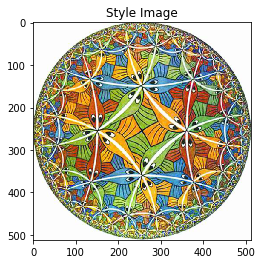

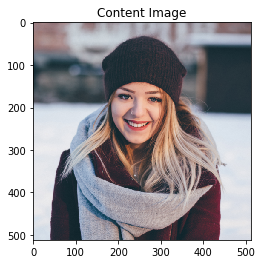

In [5]:

unloader = transforms.ToPILImage()  # 将其转化为PIL图像（Python Imaging Library） 

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # 克隆Tensor防止改变
    image = image.view(3, imsize, imsize)  # 删除添加的batch曾
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # 停一会以便更新视图


plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

## 定义主要的计算函数

In [6]:
# 计算内容损失函数
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # 由于网络的权重都是从target上迁移过来，所以在计算梯度的时候，需要把它和原始计算图分离
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        # 误差就是当前计算的内容与target之间的均方误差
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        # 开始进行反向传播算法
        self.loss.backward(retain_variables=retain_variables)
        return self.loss
    
class GramMatrix(nn.Module):
    # 计算Gram矩阵，该矩阵衡量的是任意两个特征层之间，每一个对应像素的相似度

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=特征图的数量
        # (c,d)=特征图的图像尺寸 (N=c*d)

        features = input.view(a * b, c * d)  # 将特征图图像扁平化为一个向量

        G = torch.mm(features, features.t())  # 计算gram乘积

        # 我们通过除以特征图中的像素数量来归一化特征图
        return G.div(a * b * c * d)
    
class StyleLoss(nn.Module):
    
    # 计算风格损失的函数

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        # 计算本图像的gram矩阵，并将它与target对比
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

## 迁移学习，从网络上下载vgg19网络并加载
### vgg19网络是一种特殊的卷积神经网络

In [7]:
cnn = models.vgg19(pretrained=True).features

# 如果可能就用GPU计算:
if use_cuda:
    print("use cuda")
    cnn = cnn.cuda()

use cuda


## 定义主要的内容、风格损失函数计算模块

In [8]:
# 希望计算的内容或者风格层 :
content_layers_default = ['conv_4']
#style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_layers_default = ['conv_4']

#该函数定义模型
def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    #传进来的参数包括cnn：迁移学习得来的vgg19网络，风格图片，内容图片，相对风格、内容权重，默认的内容层数据，默认的风格层数据
    cnn = copy.deepcopy(cnn)

    # 定义列表存储每一个周期的计算损失
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # 一个新的序贯网络模型
    gram = GramMatrix()  # 我们需要gram模块来计算风格目标函数

    # 如果有GPU就把这些计算挪到GPU上:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    # 将每层卷积核的数据都加载到新的网络模型上来
    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # 如果当前层模型在定义好的要计算内容的层:
                target = model(content_img).clone() #将内容图像当前层的feature信息拷贝到target中
                content_loss = ContentLoss(target, content_weight) #定义content_loss的目标函数
                model.add_module("content_loss_" + str(i), content_loss) #在新网络上加content_loss层
                content_losses.append(content_loss)

            if name in style_layers:
                # 如果当前层在指定的风格层中，进行风格层损失的计算
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            #如果不是卷积层，则做同样处理
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

### 待调整的图像可以是原始的内容图，也可以是一张噪声图像

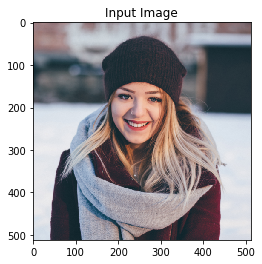

In [9]:
input_img = content_img.clone()
# 如果想从调整一张噪声图像开始，请用下面一行的代码
#input_img = torch.randn(content_img.data.size()).type(dtype)

# 将选中的待调整图打印出来:
plt.figure()
imshow(input_img.data, title='Input Image')

In [10]:
def get_input_param_optimizer(input_img):
    # 注意待优化的变量不再是神经网络的权重，而是输入图像input_img的内容本身
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

## 运行算法的主过程

In [11]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    #输入参数包括cnn网络，内容图像、风格图像、算法迭代步数，风格和内容的相对权重，默认1000:1
    """运行风格迁移的主算法过程."""
    print('正在构造风格迁移模型..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('开始优化..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("运行 {}轮:".format(run))
                print('风格损失 : {:4f} 内容损失: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()

            return style_score + content_score

        optself.deimizer.step(closure)

    # 做一些修正，防止数据超界...
    input_param.data.clamp_(0, 1)

    return input_param.data


## 展示最终结果

In [12]:
# 最终运行算法过程
output = run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300, style_weight=1000, content_weight=1)

# 展示最终结果
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

正在构造风格迁移模型..
开始优化..


NameError: name 'optself' is not defined